In [1]:
import numpy as np
import xarray as xr
from scipy.signal import butter, filtfilt
import gsw


def compute_rho(sst_glorys_day, sss_glorys_day):
    """Compute sea surface density."""
    pressure = 0  # dbar
    longitude, latitude = sst_glorys_day.longitude, sst_glorys_day.latitude
    
    SA = gsw.SA_from_SP(sss_glorys_day, pressure, longitude, latitude)
    CT = gsw.CT_from_t(SA, sst_glorys_day, pressure)
    rho_glorys_day = gsw.rho(SA, CT, pressure)
    
    # Assign metadata
    rho_glorys_day.name = "density"
    rho_glorys_day.attrs['long_name'] = "Sea Surface Density"
    rho_glorys_day.attrs['units'] = "kg/m^3"
    
    return rho_glorys_day


def compute_frontogenetic_tendency(rho_glorys_day, u_glorys_day, v_glorys_day): 
    """Compute frontogenetic tendencies."""
    g = 9.81  # gravitational acceleration (m/s^2)
    rho0 = 1025  # reference density for seawater (kg/m^3)
    
    b_glorys_day = -g * (rho_glorys_day / rho0)
    
    deg_to_m_longitude = 111320 * np.cos(np.deg2rad(u_glorys_day.latitude))
    deg_to_m_latitude = 111320
    
    b_x_deg = b_glorys_day.differentiate('longitude')
    b_y_deg = b_glorys_day.differentiate('latitude')
    
    b_x = b_x_deg / deg_to_m_longitude
    b_y = b_y_deg / deg_to_m_latitude
    
    u_x = u_glorys_day.differentiate('longitude') / deg_to_m_longitude
    u_y = u_glorys_day.differentiate('latitude') / deg_to_m_latitude
    v_x = v_glorys_day.differentiate('longitude') / deg_to_m_longitude
    v_y = v_glorys_day.differentiate('latitude') / deg_to_m_latitude

    T_b_hor = -(u_x * b_x * b_x + v_y * b_y * b_y)  # Buoyancy-related tendency
    T_v_hor = -(u_x * u_x * u_y + v_x * v_x * v_y)  # Velocity-related tendency
    
    T_b_hor.name = "T_b_hor"
    T_b_hor.attrs['long_name'] = "Frontogenetic Tendency (Buoyancy-related)"
    T_b_hor.attrs['units'] = "s^-3"
    
    T_v_hor.name = "T_v_hor"
    T_v_hor.attrs['long_name'] = "Frontogenetic Tendency (Velocity-related)"
    T_v_hor.attrs['units'] = "s^-3"
    
    return T_b_hor, T_v_hor


def apply_bandpass_filter(data, time, low_cutoff, high_cutoff):
    """Apply a bandpass filter to the data."""
    time_step_days = np.mean(np.diff(time).astype('timedelta64[s]').astype(int)) / (60 * 60 * 24)
    nyquist = 0.5 * (1 / time_step_days)
    
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(4, [low, high], btype='band')
    
    return filtfilt(b, a, data)
    
def compute_shear_vort(ds):
    # compute relative vorticity and shear
    Omega = 7.292e-5  
    f = 2 * Omega * np.sin(np.deg2rad(ds['latitude']))
    
    # Compute zonal (u) and meridional (v) velocity components from glorys_ds
    u = ds['uo']  # Zonal velocity component
    v = ds['vo']  # Meridional velocity component
    
    # Compute derivatives with respect to latitude and longitude
    # Derivatives along longitude (x-direction) using centered finite difference
    dudx = u.differentiate('longitude')  # ∂u/∂x
    dvdx = v.differentiate('longitude')  # ∂v/∂x
    
    # Derivatives along latitude (y-direction) using centered finite difference
    dudy = u.differentiate('latitude')  # ∂u/∂y
    dvdy = v.differentiate('latitude')  # ∂v/∂y
    
    # Compute relative vorticity: ζ = (∂v/∂x) - (∂u/∂y)
    relative_vorticity = dvdx - dudy
    relative_vorticity_normalized = relative_vorticity / f
    
    # Compute shear rate: γ = (∂u/∂x)^2 + (∂v/∂y)^2
    shear_rate = dudx**2 + dvdy**2
    shear_rate_normalized = shear_rate / f
    
    # Addback into the dataset
    ds['relative_vorticity_normalized'] = xr.DataArray(
        relative_vorticity_normalized, dims=['time', 'latitude', 'longitude'],
        coords={'time': ds['time'], 'latitude': ds['latitude'], 'longitude': ds['longitude']}
    )
    
    ds['shear_rate_normalized'] = xr.DataArray(
        shear_rate_normalized, dims=['time', 'latitude', 'longitude'],
        coords={'time': ds['time'], 'latitude': ds['latitude'], 'longitude': ds['longitude']}
    )

In [2]:
import xarray as xr
import numpy as np
import os
from glob import glob

# Path to the directory containing the NetCDF files
main_path = '/Volumes/external/TIW/data/glorys/winters'

# List all NetCDF files in the directory
nc_files = sorted(glob(os.path.join(main_path, '*.nc')))

# Loop through each file and process it
for nc_file in nc_files:
    print(f"Processing {nc_file}")

    # Open file
    glorys_ds = xr.open_dataset(nc_file)

    # Extract time range for display
    start_date = np.datetime_as_string(glorys_ds.time[0].values, unit='D')
    end_date = np.datetime_as_string(glorys_ds.time[-1].values, unit='D')
    print(f"GLORYS from {start_date} to {end_date}")

    # Specify depth
    depth = 0
    sfc_depth = 0

    # Time
    time = glorys_ds.sel(depth=sfc_depth, method='nearest').time 

    # Surface temp and gradient
    temp_sfc = glorys_ds.sel(depth=sfc_depth, method='nearest').thetao
    temp_gradient_sfc = np.gradient(temp_sfc.values, axis=2)

    # Remove time mean and apply bandpass filter
    temp_time_mean_sfc = temp_sfc.mean(dim="time")
    temp_anomaly_sfc = temp_sfc - temp_time_mean_sfc
    temp_anomaly_detrended_sfc = temp_anomaly_sfc - xr.polyval(
        time, temp_anomaly_sfc.polyfit(dim="time", deg=1).polyfit_coefficients
    )
    filtered_temp_depth_sfc = apply_bandpass_filter(temp_sfc, time, 1/50, 1/15)

    # Temp at depth
    temp_depth = glorys_ds.sel(depth=depth, method='nearest').thetao
    temp_time_mean = temp_depth.mean(dim="time")
    temp_anomaly = temp_depth - temp_time_mean
    temp_anomaly_detrended = temp_anomaly - xr.polyval(
        time, temp_anomaly.polyfit(dim="time", deg=1).polyfit_coefficients
    )
    filtered_temp_depth = apply_bandpass_filter(temp_depth, time, 1/50, 1/15)

    temp_gradient = np.gradient(temp_depth.values, axis=2)

    # Salinity anomaly
    sal_depth = glorys_ds.sel(depth=depth, method='nearest').so
    sal_anomaly = sal_depth - sal_depth.mean(dim="time")

    # Density
    rho_depth = compute_rho(temp_depth, sal_depth)

    # Frontogenetic tendencies
    T_b_hor, T_v_hor = compute_frontogenetic_tendency(
        rho_depth,
        glorys_ds.sel(depth=depth, method='nearest').uo,
        glorys_ds.sel(depth=depth, method='nearest').vo
    )

    # Convergence
    uo_depth = glorys_ds.sel(depth=depth, method='nearest').uo
    vo_depth = glorys_ds.sel(depth=depth, method='nearest').vo
    dx = np.gradient(glorys_ds.longitude.values)
    dy = np.gradient(glorys_ds.latitude.values)
    dx_3d = np.tile(dx, (uo_depth.shape[-2], 1))
    dy_3d = np.tile(dy[:, np.newaxis], (1, uo_depth.shape[-1]))  
    du_dx = np.gradient(uo_depth.values, axis=-1) / dx_3d
    dv_dy = np.gradient(vo_depth.values, axis=-2) / dy_3d
    convergence_sfc = -(du_dx + dv_dy)

    # Create processed dataset
    ds = xr.Dataset(
        {
            "temp_sfc": (["time", "latitude", "longitude"], temp_sfc.data),
            "temp_anomaly_sfc": (["time", "latitude", "longitude"], temp_anomaly_sfc.data),
            "temp_gradient_sfc": (["time", "latitude", "longitude"], temp_gradient_sfc.data),
            "temp_butter_sfc": (["time", "latitude", "longitude"], filtered_temp_depth_sfc.data),
            "temp_anomaly_detrended_sfc": (["time", "latitude", "longitude"], temp_anomaly_detrended_sfc.data),
            "temp": (["time", "latitude", "longitude"], temp_depth.data),
            "temp_anomaly": (["time", "latitude", "longitude"], temp_anomaly.data),
            "temp_gradient": (["time", "latitude", "longitude"], temp_gradient.data),
            "temp_butter": (["time", "latitude", "longitude"], filtered_temp_depth.data),
            "temp_anomaly_detrended": (["time", "latitude", "longitude"], temp_anomaly_detrended.data),
            "sal": (["time", "latitude", "longitude"], sal_depth.data),
            "sal_anomaly": (["time", "latitude", "longitude"], sal_anomaly.data),
            "uo": (["time", "latitude", "longitude"], uo_depth.data),
            "vo": (["time", "latitude", "longitude"], vo_depth.data),
            "convergence": (["time", "latitude", "longitude"], convergence_sfc),
            "T_b_hor": (["time", "latitude", "longitude"], T_b_hor.data),
            "T_v_hor": (["time", "latitude", "longitude"], T_v_hor.data),
        },
        coords={
            "time": temp_depth.time,
            "latitude": temp_depth.latitude,
            "longitude": temp_depth.longitude,
        }
    )

    # Compute shear vorticity or other diagnostics (assuming the function exists)
    compute_shear_vort(ds)

    # Optional: Save processed dataset to file if needed
    output_file = os.path.join(main_path, f'glorys-{start_date}-to-{end_date}-vars.nc')
    ds.to_netcdf(output_file)

    print(f"Saved processed data to {output_file}\n")

print("All files processed.")


Processing /Volumes/external/TIW/data/glorys/winters/cmems_mod_glo_phy-all_my_0.083deg_P1D-m_multi-vars_170.00W-110.00W_0.00N-10.00N_0.51m_2021-08-01-2022-02-28_regridded.nc
GLORYS from 2021-08-01 to 2022-02-28
Saved processed data to /Volumes/external/TIW/data/glorys/winters/glorys-2021-08-01-to-2022-02-28-vars.nc

Processing /Volumes/external/TIW/data/glorys/winters/cmems_mod_glo_phy_my_0.083deg_P1D-m_so-thetao-uo-vo_170.00W-110.00W_0.00N-10.00N_0.49m_2017-08-01-2018-02-28.nc
GLORYS from 2017-08-01 to 2018-02-28
Saved processed data to /Volumes/external/TIW/data/glorys/winters/glorys-2017-08-01-to-2018-02-28-vars.nc

Processing /Volumes/external/TIW/data/glorys/winters/cmems_mod_glo_phy_my_0.083deg_P1D-m_so-thetao-uo-vo_170.00W-110.00W_0.00N-10.00N_0.49m_2018-08-01-2019-02-28.nc
GLORYS from 2018-08-01 to 2019-02-28
Saved processed data to /Volumes/external/TIW/data/glorys/winters/glorys-2018-08-01-to-2019-02-28-vars.nc

Processing /Volumes/external/TIW/data/glorys/winters/cmems_mod_g

In [4]:
import matplotlib.pyplo

ds['convergence'].sel(latitude=2,longitude=-140)

<xarray.DataArray 'convergence' (time: 845)> Size: 3kB
array([ 1.55980721e-01, -2.03579683e-02, -3.32166925e-02,  1.19890943e-01,
        5.44691205e-01,  1.42107680e-01,  2.59457260e-01,  4.18330967e-01,
        3.33226144e-01,  1.01906109e+00,  2.00584841e+00,  1.02533913e+00,
        5.04556447e-02, -6.47156477e-01,  9.17670131e-02, -2.07676172e-01,
       -7.76600838e-03,  7.08283126e-01,  2.20954627e-01, -4.76593882e-01,
       -2.31544018e-01, -2.93800801e-01, -1.30187780e-01, -1.54477313e-01,
       -2.70073920e-01, -4.38371867e-01, -4.56508249e-01, -2.09909737e-01,
       -4.09299344e-01, -4.94918883e-01, -3.88431787e-01, -3.17667782e-01,
       -3.96674097e-01, -8.10195357e-02, -3.60578746e-01,  1.84533924e-01,
        3.81485999e-01, -1.63896799e-01, -1.77503705e-01,  1.49410620e-01,
        5.40832579e-02, -1.70252666e-01, -3.42080265e-01, -3.88338953e-01,
       -5.05129278e-01, -1.54835805e-02,  4.87235874e-01,  3.95682514e-01,
        2.43737251e-01,  2.55259842e-01, -8.72821584e-02, -1.33326828e-01,
       -2.52519976e-02,  1.39932364e-01, -1.81439593e-01, -1.87621698e-01,
       -2.63481051e-01, -4.80077639e-02, -2.39955306e-01, -4.46055561e-01,
       -7.77192861e-02, -1.33187205e-01, -1.81484252e-01, -3.23839188e-01,
       -2.33145386e-01, -5.75268507e-01, -6.95243478e-03, -3.23323816e-01,
        7.11638033e-02,  2.23123491e-01,  2.32756257e-01, -9.36230719e-02,
       -1.09672315e-01,  2.63881922e-01,  1.01448029e-01, -2.17672378e-01,
       -3.53056550e-01, -3.09773207e-01, -1.11608431e-02,  7.28276223e-02,
...
        7.33606339e-01, -3.22555482e-01, -1.73080474e-01, -7.53719956e-02,
        1.45386711e-01, -1.20724678e-01,  5.90008855e-01, -4.71438169e-01,
       -9.12855566e-02, -2.65694678e-01, -4.49260592e-01, -2.02985965e-02,
        1.30282655e-01, -5.51125109e-01,  7.89463967e-02,  4.02690247e-02,
       -3.11298966e-01, -1.96008906e-01, -1.67457640e-01, -4.58282620e-01,
       -3.49293232e-01, -4.12356928e-02,  7.47722983e-02,  2.60510623e-01,
        2.76219010e-01, -5.44191524e-03, -2.91528165e-01, -1.68483227e-01,
       -2.11981326e-01, -1.94606736e-01, -1.62183166e-01, -1.85000122e-01,
       -2.37896711e-01, -8.08326125e-01, -5.00500083e-01, -4.74722296e-01,
       -5.70430279e-01, -4.28128570e-01, -1.60400808e-01, -2.37073645e-01,
       -1.46471724e-01,  4.16684926e-01,  6.65718764e-02, -1.33091077e-01,
        1.08673736e-01,  7.85733387e-03,  2.55358052e-02, -1.24097280e-01,
        3.34342360e-01,  1.54568508e-01, -8.78971517e-02, -1.62322298e-01,
       -4.74916130e-01, -4.94708419e-01, -7.33927965e-01, -3.63004625e-01,
        9.48348939e-02, -3.02778751e-01, -9.08228830e-02,  3.03153396e-01,
       -1.76360175e-01, -3.35390806e-01, -2.78430134e-02, -1.78256899e-01,
       -1.54573977e-01,  1.39227808e-02,  1.21432319e-01,  2.23790973e-01,
       -3.65678042e-01, -7.65301526e-01, -6.09963357e-01, -5.28802991e-01,
       -2.90797740e-01, -1.92804515e-01, -2.32202813e-01, -1.41964436e-01,
       -7.07180053e-02], dtype=float32)
Coordinates:
    depth      float32 4B 0.494
  * time       (time) datetime64[ns] 7kB 2024-08-01 ... 2025-02-28
    latitude   float32 4B 2.0
    longitude  float32 4B -140.0

# old

In [ ]:
import numpy as np
import xarray as xr
from scipy.signal import butter, filtfilt
import gsw


def compute_rho(sst_glorys_day, sss_glorys_day):
    """Compute sea surface density."""
    pressure = 0  # dbar
    longitude, latitude = sst_glorys_day.longitude, sst_glorys_day.latitude
    
    SA = gsw.SA_from_SP(sss_glorys_day, pressure, longitude, latitude)
    CT = gsw.CT_from_t(SA, sst_glorys_day, pressure)
    rho_glorys_day = gsw.rho(SA, CT, pressure)
    
    # Assign metadata
    rho_glorys_day.name = "density"
    rho_glorys_day.attrs['long_name'] = "Sea Surface Density"
    rho_glorys_day.attrs['units'] = "kg/m^3"
    
    return rho_glorys_day


def compute_frontogenetic_tendency(rho_glorys_day, u_glorys_day, v_glorys_day): 
    """Compute frontogenetic tendencies."""
    g = 9.81  # gravitational acceleration (m/s^2)
    rho0 = 1025  # reference density for seawater (kg/m^3)
    
    b_glorys_day = -g * (rho_glorys_day / rho0)
    
    deg_to_m_longitude = 111320 * np.cos(np.deg2rad(u_glorys_day.latitude))
    deg_to_m_latitude = 111320
    
    b_x_deg = b_glorys_day.differentiate('longitude')
    b_y_deg = b_glorys_day.differentiate('latitude')
    
    b_x = b_x_deg / deg_to_m_longitude
    b_y = b_y_deg / deg_to_m_latitude
    
    u_x = u_glorys_day.differentiate('longitude') / deg_to_m_longitude
    u_y = u_glorys_day.differentiate('latitude') / deg_to_m_latitude
    v_x = v_glorys_day.differentiate('longitude') / deg_to_m_longitude
    v_y = v_glorys_day.differentiate('latitude') / deg_to_m_latitude

    T_b_hor = -(u_x * b_x * b_x + v_y * b_y * b_y)  # Buoyancy-related tendency
    T_v_hor = -(u_x * u_x * u_y + v_x * v_x * v_y)  # Velocity-related tendency
    
    T_b_hor.name = "T_b_hor"
    T_b_hor.attrs['long_name'] = "Frontogenetic Tendency (Buoyancy-related)"
    T_b_hor.attrs['units'] = "s^-3"
    
    T_v_hor.name = "T_v_hor"
    T_v_hor.attrs['long_name'] = "Frontogenetic Tendency (Velocity-related)"
    T_v_hor.attrs['units'] = "s^-3"
    
    return T_b_hor, T_v_hor


def apply_bandpass_filter(data, time, low_cutoff, high_cutoff):
    """Apply a bandpass filter to the data."""
    time_step_days = np.mean(np.diff(time).astype('timedelta64[s]').astype(int)) / (60 * 60 * 24)
    nyquist = 0.5 * (1 / time_step_days)
    
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(4, [low, high], btype='band')
    
    return filtfilt(b, a, data)
    
def compute_shear_vort(ds):
    # compute relative vorticity and shear
    Omega = 7.292e-5  
    f = 2 * Omega * np.sin(np.deg2rad(ds['latitude']))
    
    # Compute zonal (u) and meridional (v) velocity components from glorys_ds
    u = ds['uo']  # Zonal velocity component
    v = ds['vo']  # Meridional velocity component
    
    # Compute derivatives with respect to latitude and longitude
    # Derivatives along longitude (x-direction) using centered finite difference
    dudx = u.differentiate('longitude')  # ∂u/∂x
    dvdx = v.differentiate('longitude')  # ∂v/∂x
    
    # Derivatives along latitude (y-direction) using centered finite difference
    dudy = u.differentiate('latitude')  # ∂u/∂y
    dvdy = v.differentiate('latitude')  # ∂v/∂y
    
    # Compute relative vorticity: ζ = (∂v/∂x) - (∂u/∂y)
    relative_vorticity = dvdx - dudy
    relative_vorticity_normalized = relative_vorticity / f
    
    # Compute shear rate: γ = (∂u/∂x)^2 + (∂v/∂y)^2
    shear_rate = dudx**2 + dvdy**2
    shear_rate_normalized = shear_rate / f
    
    # Addback into the dataset
    ds['relative_vorticity_normalized'] = xr.DataArray(
        relative_vorticity_normalized, dims=['time', 'latitude', 'longitude'],
        coords={'time': ds['time'], 'latitude': ds['latitude'], 'longitude': ds['longitude']}
    )
    
    ds['shear_rate_normalized'] = xr.DataArray(
        shear_rate_normalized, dims=['time', 'latitude', 'longitude'],
        coords={'time': ds['time'], 'latitude': ds['latitude'], 'longitude': ds['longitude']}
    )
    
# Paths and filenames for dataset
dataset_type = 'aug-jan-2024'
base_paths = {'aug-jan-2024': '/Users/katiekohlman/Desktop/MOTIVE/tiwphase/aug-jan-2024/'}
file_configs = {
    'aug-jan-2024': {
        'temp': 'cmems_mod_glo_phy-thetao_anfc_0.083deg_PT6H-i_thetao_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
        'sal': 'cmems_mod_glo_phy-so_anfc_0.083deg_PT6H-i_so_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
        'curr': 'cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_150.00W-120.00W_0.00N-10.00N_0.49-318.13m_2024-08-20-2025-01-31.nc',
        'wcurr': 'cmems_mod_glo_phy-wcur_anfc_0.083deg_P1D-m_wo_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31_(1).nc'
    }
}

save_path = base_paths[dataset_type]
filenames = file_configs[dataset_type]

# Load datasets
temp_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["temp"]}')
sal_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["sal"]}')
curr_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["curr"]}')
wcurr_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["wcurr"]}')

# Extract time range for display
start_date = np.datetime_as_string(temp_glorys_ds.time[0].values, unit='D')
end_date = np.datetime_as_string(temp_glorys_ds.time[-1].values, unit='D')
print(f"GLORYS from {start_date} to {end_date}")

# Specify depth
depth = 0
sfc_depth = 0

time = temp_glorys_ds.sel(depth=sfc_depth, method='nearest').time 
temp_sfc = temp_glorys_ds.sel(depth=sfc_depth, method='nearest').thetao
temp_gradient_sfc = np.gradient(temp_sfc.values, axis=2)

# Remove time mean and apply bandpass filter
temp_time_mean_sfc = temp_sfc.mean(dim="time")
temp_anomaly_sfc = temp_sfc - temp_time_mean_sfc
temp_anomaly_detrended_sfc = temp_anomaly_sfc - xr.polyval(time, temp_anomaly_sfc.polyfit(dim="time", deg=1).polyfit_coefficients)
filtered_temp_depth_sfc = apply_bandpass_filter(temp_sfc, time, 1/50, 1/15)

# Calculate anomaly and bandpass filter for temperature at specified depth
temp_depth = temp_glorys_ds.sel(depth=depth, method='nearest').thetao
temp_time_mean = temp_depth.mean(dim="time")
temp_anomaly = temp_depth - temp_time_mean
temp_anomaly_detrended = temp_anomaly - xr.polyval(time, temp_anomaly.polyfit(dim="time", deg=1).polyfit_coefficients)
filtered_temp_depth = apply_bandpass_filter(temp_depth, time, 1/50, 1/15)

temp_gradient = np.gradient(temp_depth.values, axis=2)

# Compute salinity anomaly
sal_depth = sal_glorys_ds.sel(depth=depth, method='nearest').so
sal_anomaly = sal_depth - sal_depth.mean(dim="time")

# Compute density
rho_depth = compute_rho(temp_depth, sal_depth)

# Compute frontogenetic tendencies
T_b_hor, T_v_hor = compute_frontogenetic_tendency(
    rho_depth, 
    curr_glorys_ds.sel(depth=depth, method='nearest').uo, 
    curr_glorys_ds.sel(depth=depth, method='nearest').vo
)

# Compute convergence
uo_depth = curr_glorys_ds.sel(depth=depth, method='nearest').uo
vo_depth = curr_glorys_ds.sel(depth=depth, method='nearest').vo
dx = np.gradient(curr_glorys_ds.longitude.values)
dy = np.gradient(curr_glorys_ds.latitude.values)
dx_3d = np.tile(dx, (uo_depth.shape[-2], 1))
dy_3d = np.tile(dy[:, np.newaxis], (1, uo_depth.shape[-1]))  
du_dx = np.gradient(uo_depth.values, axis=-1) / dx_3d
dv_dy = np.gradient(vo_depth.values, axis=-2) / dy_3d
convergence_sfc = -(du_dx + dv_dy)

# Interpolate vertical velocity
wo_depth = wcurr_glorys_ds.sel(depth=depth, method='nearest').wo
wo_interp = wo_depth.interp(time=curr_glorys_ds.time)

# Create dataset
ds = xr.Dataset(
    {
        "temp_sfc": (["time", "latitude", "longitude"], temp_sfc.data),
        "temp_anomaly_sfc": (["time", "latitude", "longitude"], temp_anomaly_sfc.data),
        "temp_gradient_sfc": (["time", "latitude", "longitude"], temp_gradient_sfc.data),
        "temp_butter_sfc": (["time", "latitude", "longitude"], filtered_temp_depth_sfc.data),
        "temp_anomaly_detrended_sfc": (["time", "latitude", "longitude"], temp_anomaly_detrended_sfc.data),
        "temp": (["time", "latitude", "longitude"], temp_depth.data),
        "temp_anomaly": (["time", "latitude", "longitude"], temp_anomaly.data),
        "temp_gradient": (["time", "latitude", "longitude"], temp_gradient.data),
        "temp_butter": (["time", "latitude", "longitude"], filtered_temp_depth.data),
        "temp_anomaly_detrended": (["time", "latitude", "longitude"], temp_anomaly_detrended.data),
        "sal": (["time", "latitude", "longitude"], sal_depth.data),
        "sal_anomaly": (["time", "latitude", "longitude"], sal_anomaly.data),
        "uo": (["time", "latitude", "longitude"], uo_depth.data),
        "vo": (["time", "latitude", "longitude"], vo_depth.data),
        "wo": (["time", "latitude", "longitude"], wo_interp.data),
        "convergence": (["time", "latitude", "longitude"], convergence_sfc.data),
        "T_b_hor": (["time", "latitude", "longitude"], T_b_hor.data),
        "T_v_hor": (["time", "latitude", "longitude"], T_v_hor.data),
    },
    coords={
        "time": temp_depth.time,
        "latitude": temp_depth.latitude,
        "longitude": temp_depth.longitude,
    }
)


compute_shear_vort(ds)

# work in progress

In [2]:
import xarray as xr
ds = xr.open_dataset('/Users/katiekohlman/Desktop/TIW/netCDF/glorys-2024-08-20-to-2025-01-31-vars.nc')

def compute_N2(rho):
    """Compute Brunt-Väisälä frequency squared (N^2) from density."""
    g = 9.81  # m/s^2
    rho0 = 1025  # kg/m^3
    
    # Compute vertical density gradient
    rho_z = rho.differentiate('depth')
    
    # Compute N^2
    N2 = - (g / rho0) * rho_z
    N2.name = "N2"
    N2.attrs['long_name'] = "Brunt-Väisälä frequency squared"
    N2.attrs['units'] = "s^-2"
    
    return N2

def compute_buoyancy_gradient_evolution(rho, u, v, w):
    """Compute frontogenetic tendency using buoyancy gradients."""
    
    # Compute buoyancy
    g = 9.81  # m/s^2
    rho0 = 1025  # kg/m^3
    b = -g * (rho / rho0)
    
    # Convert degrees to meters for differentiation
    deg_to_m_longitude = 111320 * np.cos(np.deg2rad(b.latitude))
    deg_to_m_latitude = 111320
    
    # Compute horizontal buoyancy gradients
    b_x = b.differentiate('longitude') / deg_to_m_longitude
    b_y = b.differentiate('latitude') / deg_to_m_latitude
    
    # Compute horizontal velocity gradients
    u_x = u.differentiate('longitude') / deg_to_m_longitude
    u_y = u.differentiate('latitude') / deg_to_m_latitude
    v_x = v.differentiate('longitude') / deg_to_m_longitude
    v_y = v.differentiate('latitude') / deg_to_m_latitude

    # HCL Term
    HCL = -2 * (b_x * (u_x * b_x + v_x * b_y) + b_y * (u_y * b_x + v_y * b_y))
    
    # Compute N^2
    N2 = compute_N2(rho)
    
    # Compute vertical velocity gradients
    w_x = w.differentiate('longitude') / deg_to_m_longitude
    w_y = w.differentiate('latitude') / deg_to_m_latitude

    # DV_ADV Term
    DV_ADV = -2 * (b_x * (N2 * w_x) + b_y * (N2 * w_y))
    
    # Compute total frontogenesis tendency
    frontogenesis_tendency = HCL + DV_ADV
    
    return N2, HCL, DV_ADV, frontogenesis_tendency



import numpy as np
import xarray as xr
import gsw

# Paths and filenames
dataset_type = 'aug-jan-2024'
base_path = '/Users/katiekohlman/Desktop/MOTIVE/tiwphase/aug-jan-2024/'
file_configs = {
    'temp': 'cmems_mod_glo_phy-thetao_anfc_0.083deg_PT6H-i_thetao_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
    'sal': 'cmems_mod_glo_phy-so_anfc_0.083deg_PT6H-i_so_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
    'curr': 'cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_150.00W-120.00W_0.00N-10.00N_0.49-318.13m_2024-08-20-2025-01-31.nc',
    'wcurr': 'cmems_mod_glo_phy-wcur_anfc_0.083deg_P1D-m_wo_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31_(1).nc'
}

# Load datasets without chunking and select depth range (0-30m)
datasets = {
    key: xr.open_dataset(f"{base_path}/{file}").sel(depth=slice(0, 30))
    for key, file in file_configs.items()
}

# Extract variables
SP = datasets['sal']['so']
T = datasets['temp']['thetao']
pressure = datasets['sal']['depth']
longitude, latitude = datasets['sal'].longitude, datasets['sal'].latitude

# Compute Absolute Salinity (SA) & Conservative Temperature (CT)
SA = gsw.SA_from_SP(SP, pressure, longitude, latitude)
CT = gsw.CT_from_t(SA, T, pressure)

# Compute density
rho = gsw.rho(SA, CT, pressure)

# Free up memory
del SP, T, SA, CT

# Interpolate vertical velocity `wo` to match current time grid
wo = datasets['wcurr']['wo'].interp(time=datasets['curr'].time)

# Compute frontogenetic terms
N2, HCL, DV_ADV, frontogenesis_tendency = compute_buoyancy_gradient_evolution(
    rho, datasets['curr'].uo, datasets['curr'].vo, wo
)

# Load computed variables into memory
for var in [N2, HCL, DV_ADV, rho]:
    var.load()

# Print size checks
for name, var in zip(['rho', 'wo', 'N2', 'HCL', 'DV_ADV'], [rho, wo, N2, HCL, DV_ADV]):
    print(f'Size of {name}:', np.shape(var))




In [10]:
import numpy as np
import xarray as xr
import gsw

# Paths and filenames
dataset_type = 'aug-jan-2024'
base_paths = {'aug-jan-2024': '/Users/katiekohlman/Desktop/MOTIVE/tiwphase/aug-jan-2024/'}
file_configs = {
    'aug-jan-2024': {
        'temp': 'cmems_mod_glo_phy-thetao_anfc_0.083deg_PT6H-i_thetao_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
        'sal': 'cmems_mod_glo_phy-so_anfc_0.083deg_PT6H-i_so_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31.nc',
        'curr': 'cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_uo-vo_150.00W-120.00W_0.00N-10.00N_0.49-318.13m_2024-08-20-2025-01-31.nc',
        'wcurr': 'cmems_mod_glo_phy-wcur_anfc_0.083deg_P1D-m_wo_150.00W-120.00W_0.00N-10.00N_0.49-109.73m_2024-08-20-2025-01-31_(1).nc'
    }
}

save_path = base_paths[dataset_type]
filenames = file_configs[dataset_type]

# Use chunking to avoid memory overload
chunks = {'time': 50, 'depth': 5, 'latitude': 50, 'longitude': 50}

# Load only required depth range (0-30m)
temp_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["temp"]}', chunks=chunks).sel(depth=slice(0, 30))
sal_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["sal"]}', chunks=chunks).sel(depth=slice(0, 30))
curr_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["curr"]}', chunks=chunks).sel(depth=slice(0, 30))
wcurr_glorys_ds = xr.open_dataset(f'{save_path}/{filenames["wcurr"]}', chunks=chunks).sel(depth=slice(0, 30))

# Extract temperature & salinity
SP = sal_glorys_ds['so']
T = temp_glorys_ds['thetao']
pressure = sal_glorys_ds['depth']
longitude, latitude = sal_glorys_ds.longitude, sal_glorys_ds.latitude

# Compute Absolute Salinity (SA) & Conservative Temperature (CT)
SA = gsw.SA_from_SP(SP, pressure, longitude, latitude)
CT = gsw.CT_from_t(SA, T, pressure)

# Compute density
rho = gsw.rho(SA, CT, pressure)

# Drop unnecessary variables to free memory
del SP, T, SA, CT

# Interpolate vertical velocity `wo` to match the time grid of currents
wo = wcurr_glorys_ds['wo'].interp(time=curr_glorys_ds.time)

# Compute frontogenetic terms
N2, HCL, DV_ADV, frontogenesis_tendency = compute_buoyancy_gradient_evolution(rho, curr_glorys_ds.uo, curr_glorys_ds.vo, wo)

# Ensure variables are loaded into memory (remove chunking)
N2 = N2.load()
HCL = HCL.load()
DV_ADV = DV_ADV.load()
rho = rho.load()

# Check sizes
print('Size of rho:', np.shape(rho))
print('Size of wo:', np.shape(wo))
print('Size of N2:', np.shape(N2))
print('Size of HCL:', np.shape(HCL))
print('Size of DV_ADV:', np.shape(DV_ADV))

ds['N2'] = N2.sel(depth=0, method='nearest')
ds['HCL'] = HCL.sel(depth=0, method='nearest')
ds['DV_ADV'] = DV_ADV.sel(depth=0, method='nearest')
ds['rho'] = rho.sel(depth=0, method='nearest')

# Ensure no chunking metadata remains
for var in ['N2', 'HCL', 'DV_ADV', 'rho']:
    ds[var].encoding.clear()


AttributeError: module 'numba' has no attribute 'core'

In [ ]:
ds['HCL']

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset('/Volumes/external/TIW/jupyter_notebooks/cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_170.00W-110.00W_2.00S-10.00N_0.49-92.33m_2017-07-30-2021-06-30.nc')

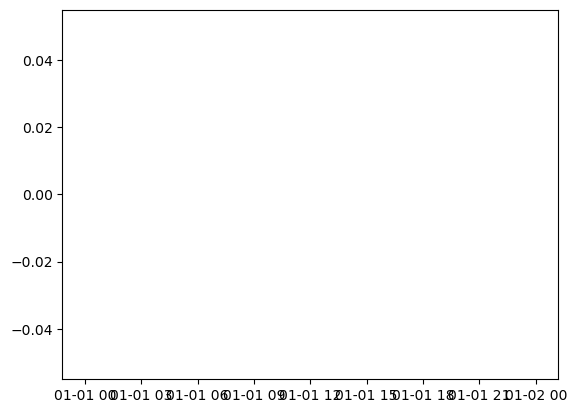

In [16]:
plt.plot(ds.time,ds.sel(latitude=0, longitude=-110, depth=10, method='nearest').zos)

In [3]:
ds

<xarray.Dataset> Size: 108GB
Dimensions:    (depth: 22, latitude: 145, longitude: 721, time: 1432)
Coordinates:
  * depth      (depth) float32 88B 0.494 1.541 2.646 3.819 ... 65.81 77.85 92.33
  * latitude   (latitude) float32 580B -2.0 -1.917 -1.833 ... 9.833 9.917 10.0
  * longitude  (longitude) float32 3kB -170.0 -169.9 -169.8 ... -110.1 -110.0
  * time       (time) datetime64[ns] 11kB 2017-07-30 2017-07-31 ... 2021-06-30
Data variables:
    mlotst     (time, latitude, longitude) float64 1GB ...
    so         (time, depth, latitude, longitude) float64 26GB ...
    thetao     (time, depth, latitude, longitude) float64 26GB ...
    uo         (time, depth, latitude, longitude) float64 26GB ...
    vo         (time, depth, latitude, longitude) float64 26GB ...
    zos        (time, latitude, longitude) float64 1GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3